In [1]:
import numpy as np
from numpy import sin, cos, exp, pi
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fminbound
import numpy.linalg
import time

'''
Program to calculate the phasea diagram of the anisotropic generalized BHZ model with inversion-symmetric breaking coupling
C=C1 where coupling is of the form ty*sy. The algorithm first looks for points in the C-u plane where there are Weyl nodes, this
is the Weyl semimetallic phase. For all the other points it calculates the Z2 invariant.
has_Weyl says whether (C, u) has Weyl nodes or not
'''

-1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

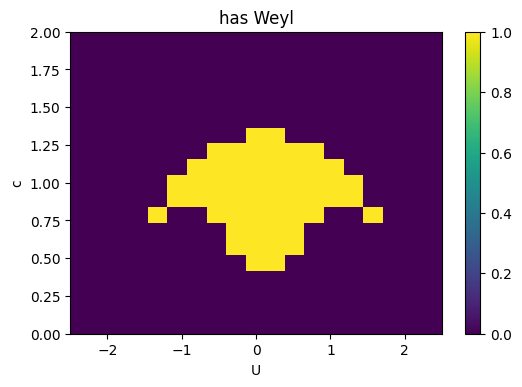

0 1 2 

KeyboardInterrupt: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from numpy import cos, sin, exp, min, max
from numpy.linalg import eigh
from ipywidgets import interact
import matplotlib
from matplotlib import rcParams
matplotlib.rcParams['figure.dpi'] = 100
pi = np.pi

k_res = 16 #resolution of BZ when looking for Weyl nodes
u_res = 20
c_res = 20
c_min = 0 #bounding C values of plot
c_max = 2
vx = 0.8
u_min = -2.5
u_max = 2.5 #bounding u values of plot

start = time.time()

#matrix to bring H into the chiral form of [[0, h], [h^+, 0]]
U_4 = 1/np.sqrt(2.)*np.array([[1, 0, 0, -1j],[0, 1, -1j, 0],[0, 1, 1j, 0],[1, 0, 0, 1j]])
   
uvals = np.linspace(u_min, u_max, u_res)
emin, emax = [], []
# Resolution of half of Brillouin zone: kres
Q = np.zeros([2*k_res, 2*k_res]) #total chiral charge of one plaquette at (kx, ky)
has_Weyl = np.zeros([c_res, u_res], dtype = bool)

cno=-1

cvals = np.linspace(c_min, c_max, c_res)
for CC in cvals:
    print(cno, end=" ")
    cno+=1; uno =-1
    for u in uvals:
        uno+=1
        #setup Hamiltonian at given C, u pair
        HH = np.zeros((2*k_res, 2*k_res, 4, 4), dtype=complex)
        kvals = np.linspace(-pi, pi, 2*k_res, endpoint=False)
        ky, kx = np.meshgrid(kvals, kvals)
        HH[:, :, 0, 0] = u+vx*cos(kx)+cos(ky)
        HH[:, :, 0, 1] = vx*sin(kx)-1.j*sin(ky)
        HH[:, :, 1, 0] =  HH[:, :, 0, 1].conj() 
        HH[:, :, 1, 1] = -HH[:, :, 0, 0]
        HH[:, :, 2, 2] = u+vx*cos(kx)+cos(ky)
        HH[:, :, 2, 3] = -vx*sin(kx)-1.j*sin(ky)
        HH[:, :, 3, 2] =  HH[:, :, 2, 3].conj() 
        HH[:, :, 3, 3] = -HH[:, :, 2, 2]
        HH[:, :, 0, 3] = -CC
        HH[:, :, 1, 2] = -HH[:, :, 0, 3] 
        HH[:, :, 2, 1] = HH[:, :, 1, 2].conj()
        HH[:, :, 3, 0] = HH[:, :, 0, 3].conj()


        #calculate h from H
        HH_antidiag = (np.matmul(np.matmul(U_4,HH), (U_4.conj().T)))
        dett = HH_antidiag[:, :, 0, 2]*HH_antidiag[:, :, 1, 3] \
               - HH_antidiag[:, :, 0, 3]*HH_antidiag[:, :, 1, 2] #determinant of (kx, ky)

        dettx  = np.roll(dett, 1, axis=0) 
        detty  = np.roll(dett, 1, axis=1) #determinant of h(kx, ky + delta ky)
        dettxy = np.roll(np.roll(dett, 1, axis=1), 1, axis=0)

        Q = (np.angle(dett/dettx) + np.angle(dettx/dettxy)  \
            + np.angle(dettxy/detty) + np.angle(detty/dett)) #calculate topological charge of plaquette
        if (max(abs(Q))>0.1): has_Weyl[cno, uno] = True #if there is some charge somewhere then we know we are in the Weyl phase (due to Weyl nodes)


plt.pcolormesh(uvals, cvals, has_Weyl) #plot the Weyl phase
plt.title("has Weyl")
plt.xlabel("U")
plt.ylabel("c")
plt.colorbar()
plt.show()

      
#above we calculated the Weyl phase, below we calculate the Z2 invariant for the other (C,u) points

z2_all = np.zeros([c_res, u_res])

c_count = -1
for C in np.linspace(c_min, c_max, c_res):
    c_count+=1
    print(c_count, end = " ")

    T = np.array([[0, 0, -1j, 0], [0, 0, 0, -1j], [1j, 0, 0, 0], [0, 1j, 0, 0]])

    def fix_gauge(nkx, nky, HH, ee, vv): #fix the gauge as described in the Fukui et Hatsugai paper

        # time reversed partner:
        nkxt, nkyt = -nkx, -nky
        # Check eigenvectors, fix gauge:
        for jj in range(4):
            dpsi = ee[nkxt, nkyt, jj]*vv[nkxt, nkyt, :, jj] \
                 - HH[nkxt, nkyt, :, :]@vv[nkxt, nkyt, :, jj]
            psierr = sum(abs(dpsi)**2)
            if psierr>1e-10: 
                print("Eigvec error before gauge fixing at ", nkx, nky, jj)    
            vv[nkxt, nkyt, :, jj] = T@vv[nkx, nky, :, jj].conj()
            dpsi = ee[nkxt, nkyt, jj]*vv[nkxt, nkyt, :, jj] \
                 - HH[nkxt, nkyt, :, :]@vv[nkxt, nkyt, :, jj]
            psierr = sum(abs(dpsi)**2)
            if psierr>1e-10: 
                print("Eigvec error after gauge fixing at ", nkx, nky, jj)    
        return HH, ee, vv

    emin, emax = [], []
    # Resolution of half of Brillouin zone:

    kvals = np.linspace(-pi, pi, 2*k_res, endpoint=False)
    ky, kx = np.meshgrid(kvals, kvals)

    chern = []
    chern0 = []
    z2 = []
    
    u_count = -1
    for u in uvals:
        u_count +=1
        
        if(has_Weyl[c_count, u_count] == True): z2_all[c_count, u_count]=0.5; continue #if we are in Weyl phase, don't calculate Z2, just continue
        #Weyl phase denoted by z2 = 0.5 in the line above
        
        HH = np.zeros((2*k_res, 2*k_res, 4, 4), dtype=complex)
        #Hamiltonian calculation
        HH[:, :, 0, 0] = u+vx*cos(kx)+cos(ky)
        HH[:, :, 0, 1] = vx*sin(kx)-1.j*sin(ky)
        HH[:, :, 1, 0] =  HH[:, :, 0, 1].conj() 
        HH[:, :, 1, 1] = -HH[:, :, 0, 0]

        HH[:, :, 2, 2] = u+vx*cos(kx)+cos(ky)
        HH[:, :, 2, 3] = -vx*sin(kx)-1.j*sin(ky)
        HH[:, :, 3, 2] =  HH[:, :, 2, 3].conj() 
        HH[:, :, 3, 3] = -HH[:, :, 2, 2]

        HH[:, :, 0, 3] = -C
        HH[:, :, 1, 2] = -HH[:, :, 0, 3] 
        HH[:, :, 2, 1] = HH[:, :, 1, 2].conj()
        HH[:, :, 3, 0] = HH[:, :, 0, 3].conj()
  
        
        
        
        ee, vv = np.linalg.eigh(HH)
        
        
        #print("C = ", C, "u = ", u, "gap = ", 2*emin[len(emin)-1])
        kres=k_res
        # Fix gauge:
        DD = np.zeros((2*kres, 2*kres))
        # Lower half of Brillouin zone:
        for nkx in range(1, kres):
            HH, ee, vv = fix_gauge(nkx, 0, HH, ee, vv)
            DD[nkx, 0] = 1
        for nkx in range(kres+1, 2*kres):
            HH, ee, vv = fix_gauge(nkx, kres, HH, ee, vv)
            DD[nkx, kres] = 1
        for nky in range(1, kres):
            for nkx in range(2*kres):
                HH, ee, vv = fix_gauge(nkx, nky, HH, ee, vv)
                DD[nkx, nky] = 1
                
        
        # TRIM:    
        for nkx in (0, kres):
            for nky in (0, kres):
                DD[nkx, nky] = 2
                vv[nkx, nky, :, 1] = T@vv[nkx, nky, :, 0].conj()
                vv[nkx, nky, :, 3] = T@vv[nkx, nky, :, 2].conj()
                for jj in range(4):
                    dpsi = ee[nkx, nky, jj]*vv[nkx, nky, :, jj] \
                         - HH[nkx, nky, :, :]@vv[nkx, nky, :, jj]
                psierr = sum(abs(dpsi)**2)
                if psierr>1e-10: 
                    print("Eigvec error after gauge fixing at ", nkx, nky, jj)    


        # Calculate overlap matrices: 
        Mx = np.zeros((2*kres, 2*kres, 2, 2), dtype=complex)
        My = np.zeros_like(Mx)
        detMx = np.zeros((2*kres, 2*kres), dtype=complex)
        detMy = np.zeros_like(detMx)
        for j1 in (0, 1):
            for j2 in (0, 1):
                Mx[:, :, j1, j2] = np.sum(vv[:, :, :, j1].conj() \
                            *  np.roll(vv[:, :, :, j2], -1, axis=0), axis=2)
                My[:, :, j1, j2] = np.sum(vv[:, :, :, j1].conj() \
                            *  np.roll(vv[:, :, :, j2], -1, axis=1), axis=2)
        detMx = np.linalg.det(Mx)
        detMy = np.linalg.det(My)
        #calculate F and Ftilde according to Fukui and Hatsugai method for Z_2 and Chern number calculation
        FF = np.angle(detMx * np.roll(detMx, -1, axis=1).conj() \
                      * detMy.conj() * np.roll(detMy, -1, axis=0)) / (2.*pi)
        Ftilde = (np.angle(detMx) + np.angle(np.roll(detMx, -1, axis=1).conj()) \
                + np.angle(detMy.conj()) + np.angle(np.roll(detMy, -1, axis=0))) / (2.*pi)
        chern.append(np.sum(FF-Ftilde))
        chern0.append(np.sum(Ftilde))
        z2.append((np.round(np.sum(FF[:, :kres]-Ftilde[:, :kres])))%2)
        z2_all[c_count, u_count] = z2[len(z2)-1]
    

  

          
plt.pcolormesh(uvals, cvals, z2_all)
plt.colorbar()
plt.title("Topological phase diagram of the generalized BHZ model")
plt.ylabel("Interlayer coupling parameter, C")
plt.xlabel("Onsite Zeeman parameter, u")
plt.savefig("phase diagrammm 2.pdf", dpi = 500)
plt.show()
            
np.save('phase diagram numpy data 2', z2_all)
np.save('phase diagram C axis 2', cvals)
np.save('phase diagram u axis 2', uvals)
np.save('phase diagram ures 2', u_res)
np.save('phase diagram cres 2', c_res)

plt.contourf(uvals, cvals, z2_all, 2)
plt.colorbar()
plt.ylabel("Interlayer coupling parameter, C")
plt.xlabel("Onsite Zeeman parameter, u")
plt.show()

end = time.time()
print(end - start)